# Group 18 — Dementia Prediction Project
## Step 3: SMOTE Preprocessing + Train/Test Split

> **Prerequisites:** Run Step 1 first to generate `dementia_clean.csv`

### Bugs Fixed
| # | Location | Bug | Fix |
|---|----------|-----|-----|
| 1 | Cell 2 | `!pip install imbalanced-learn` was commented out — `imblearn` never installed, causing `ModuleNotFoundError` | Made it an executable install cell |
| 2 | Cell 6 | `study1_rundmc` and `study1_scans` are `bool` dtype (from `pd.get_dummies`) — SMOTE requires all-numeric input, causing a `ValueError` | Cast both columns to `int` before scaling/SMOTE |

In [1]:
import os

# ── 路径配置 ──────────────────────────────
DATA_DIR    = '../Data/'
FIGURES_DIR = '../Outputs/Figures/'
MODELS_DIR  = '../Outputs/Models/'
RESULTS_DIR = '../Outputs/Results/'

# 确保文件夹存在
for d in [FIGURES_DIR, MODELS_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)

In [2]:
import subprocess, sys

def install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "--quiet"])

install("scikit-learn")
install("imbalanced-learn")

print("✓ scikit-learn and imbalanced-learn installed")


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


✓ scikit-learn and imbalanced-learn installed



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 0. Load Data

In [4]:
df = pd.read_csv(RESULTS_DIR + 'dementia_clean.csv')
print(f"Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

bool_cols = df.select_dtypes(include='bool').columns.tolist()
if bool_cols:
    df[bool_cols] = df[bool_cols].astype(int)
    print(f"✓ Cast bool columns to int: {bool_cols}")

print(f"\nClass distribution:")
print(df['dementia'].value_counts().rename({0.0: 'No Dementia', 1.0: 'Dementia'}))
df.head()

Loaded: 1842 rows, 22 columns

Class distribution:
dementia
No Dementia    1726
Dementia         82
Name: count, dtype: int64


,ID,age,gender,dementia,dementia_all,educationyears,EF,PS,Global,diabetes,...,hypercholesterolemia,lacunes_num,fazekas_cat,study,study1,SVD Simple Score,SVD Amended Score,Fazekas,lac_count,CMB_count
0,1,52.67,male,0.0,0,11.0,-2.403333,-1.290000,-1.287000,0,...,Yes,more-than-zero,2 to 3,scans,scans,3.0,7.0,3,>5,>=1
1,10,64.58,male,0.0,0,10.0,1.280000,0.360000,0.744000,0,...,Yes,more-than-zero,0 to 1,scans,scans,2.0,3.0,1,1 to 2,>=1
2,100,74.92,male,0.0,0,8.0,-1.440000,-1.520000,-0.922000,0,...,Yes,more-than-zero,0 to 1,scans,scans,1.0,2.0,1,1 to 2,0
3,101,74.83,male,1.0,1,9.0,NaN,-2.136271,-1.301102,0,...,Yes,more-than-zero,2 to 3,scans,scans,2.0,4.0,2,3 to 5,0
4,102,79.25,male,0.0,0,10.0,-0.920000,-1.493333,-0.924000,0,...,Yes,more-than-zero,2 to 3,scans,scans,2.0,3.0,2,1 to 2,0


## 1. Define Feature Sets

Two feature sets are prepared:
- **LR features** — uses only `Global` to avoid multicollinearity between EF, PS, Global (for Logistic Regression)
- **RF features** — includes all three cognitive scores (safe for tree-based models like Random Forest / XGBoost)

In [4]:
FEATURES_LR = [
    'age', 'gender', 'educationyears',
    'Global',                          # single cognitive score avoids multicollinearity
    'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking',
    'Fazekas', 'lac_count', 'CMB_count',
    'study1_rundmc', 'study1_scans'
]

FEATURES_RF = [
    'age', 'gender', 'educationyears',
    'EF', 'PS', 'Global',             # all three cognitive scores safe for tree models
    'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking',
    'Fazekas', 'lac_count', 'CMB_count',
    'study1_rundmc', 'study1_scans'
]

TARGET = 'dementia'

# Verify all expected columns are present
missing = [f for f in FEATURES_RF if f not in df.columns]
print(f"Missing columns: {missing if missing else 'None — all features present ✓'}")
print(f"\nLR feature set ({len(FEATURES_LR)}): {FEATURES_LR}")
print(f"\nRF feature set ({len(FEATURES_RF)}): {FEATURES_RF}")

Missing columns: None — all features present ✓

LR feature set (13): ['age', 'gender', 'educationyears', 'Global', 'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking', 'Fazekas', 'lac_count', 'CMB_count', 'study1_rundmc', 'study1_scans']

RF feature set (15): ['age', 'gender', 'educationyears', 'EF', 'PS', 'Global', 'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking', 'Fazekas', 'lac_count', 'CMB_count', 'study1_rundmc', 'study1_scans']


## 2. Train / Test Split

> ⚠️ **SMOTE must only be applied to training data.**  
> Splitting *before* SMOTE ensures no synthetic samples leak into the test set, which would cause artificially inflated evaluation metrics.

A stratified 80/20 split preserves the ~4.5% dementia rate in both partitions.

In [5]:
X = df[FEATURES_RF]
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y        # preserves dementia ratio in both splits
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set:  {X_test.shape[0]} samples")
print(f"\nClass distribution BEFORE SMOTE:")
print(f"  Train — No Dementia: {(y_train==0).sum():4d}, "
      f"Dementia: {(y_train==1).sum():3d} ({y_train.mean()*100:.1f}% positive)")
print(f"  Test  — No Dementia: {(y_test==0).sum():4d}, "
      f"Dementia: {(y_test==1).sum():3d} ({y_test.mean()*100:.1f}% positive)")

Train set: 1446 samples
Test set:  362 samples

Class distribution BEFORE SMOTE:
  Train — No Dementia: 1380, Dementia:  66 (4.6% positive)
  Test  — No Dementia:  346, Dementia:  16 (4.4% positive)


## 3. Feature Scaling

`StandardScaler` transforms each feature to mean = 0, std = 1.

- **Required** for Logistic Regression (sensitive to feature magnitude)
- **Best practice** for all models when features are on different scales
- ⚠️ Scaler is **fit on training data only**, then applied to test data — prevents data leakage

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)       # fit + transform on train
X_test_scaled  = scaler.transform(X_test)            # transform only on test — DO NOT refit

# Convert back to DataFrames to preserve column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURES_RF)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=FEATURES_RF)

print("✓ Scaling complete (fit on train only)")
print(f"  Train mean (should be ~0): {X_train_scaled.mean().round(3).values}")
print(f"  Test  mean (may deviate):  {X_test_scaled.mean().round(3).values}")

✓ Scaling complete (fit on train only)
  Train mean (should be ~0): [ 0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0.  0. -0.  0. -0.]
  Test  mean (may deviate):  [ 0.011 -0.021 -0.066  0.012  0.053  0.052  0.031 -0.031 -0.082  0.008
 -0.022 -0.066 -0.038 -0.07  -0.03 ]


## 4. Apply SMOTE (Training Set Only)

**SMOTE** (Synthetic Minority Oversampling Technique) creates synthetic dementia cases by interpolating between existing minority-class samples in feature space.

Result: balanced 50/50 training set, while the test set retains the real-world distribution.

In [7]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)

print("Class distribution AFTER SMOTE:")
print(f"  Train — No Dementia: {(y_train_sm==0).sum()}, "
      f"Dementia: {(y_train_sm==1).sum()} ({y_train_sm.mean()*100:.1f}% positive)")
print(f"\n✓ Test set is NOT resampled (real-world distribution preserved)")
print(f"  Test  — No Dementia: {(y_test==0).sum()}, "
      f"Dementia: {(y_test==1).sum()} ({y_test.mean()*100:.1f}% positive)")

Class distribution AFTER SMOTE:
  Train — No Dementia: 1380, Dementia: 1380 (50.0% positive)

✓ Test set is NOT resampled (real-world distribution preserved)
  Test  — No Dementia: 346, Dementia: 16 (4.4% positive)


## 5. Prepare Logistic Regression Feature Subset

In [8]:
# LR uses only Global (not EF/PS) to avoid multicollinearity
LR_COLS = [f for f in FEATURES_LR if f in X_train_sm.columns]
X_train_lr = X_train_sm[LR_COLS]
X_test_lr  = X_test_scaled[LR_COLS]

print(f"LR feature set ({len(LR_COLS)} features): {LR_COLS}")
print(f"RF feature set ({len(FEATURES_RF)} features): {FEATURES_RF}")

LR feature set (13 features): ['age', 'gender', 'educationyears', 'Global', 'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking', 'Fazekas', 'lac_count', 'CMB_count', 'study1_rundmc', 'study1_scans']
RF feature set (15 features): ['age', 'gender', 'educationyears', 'EF', 'PS', 'Global', 'diabetes', 'hypertension', 'hypercholesterolemia', 'smoking', 'Fazekas', 'lac_count', 'CMB_count', 'study1_rundmc', 'study1_scans']


## 6. Visualise Class Balance Before vs After SMOTE

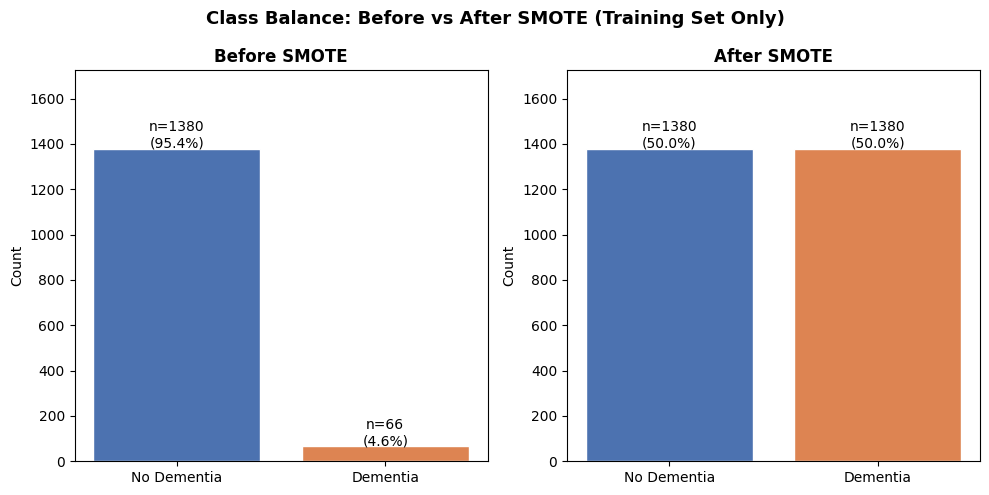

✓ Saved: SMOTE_class_balance.png


In [ ]:
colors = ['#4C72B0', '#DD8452']
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Class Balance: Before vs After SMOTE (Training Set Only)',
             fontsize=13, fontweight='bold')

for ax, counts, title in zip(
    axes,
    [[(y_train==0).sum(),    (y_train==1).sum()],
     [(y_train_sm==0).sum(), (y_train_sm==1).sum()]],
    ['Before SMOTE', 'After SMOTE']
):
    bars = ax.bar(['No Dementia', 'Dementia'], counts, color=colors, edgecolor='white')
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Count')
    for i, v in enumerate(counts):
        ax.text(i, v + 5, f'n={v}\n({v/sum(counts)*100:.1f}%)', ha='center', fontsize=10)
    ax.set_ylim(0, max(counts) * 1.25)

plt.tight_layout()
plt.savefig(FIGURES_DIR + 'SMOTE_class_balance.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print("✓ Saved: SMOTE_class_balance.png")

## 7. Save Preprocessed Splits

In [ ]:
X_train_sm.to_csv(RESULTS_DIR + 'X_train_rf.csv',    index=False)  # RF/XGBoost train (SMOTE applied)
X_test_scaled.to_csv(RESULTS_DIR + 'X_test_rf.csv',  index=False)  # RF/XGBoost test
X_train_lr.to_csv(RESULTS_DIR + 'X_train_lr.csv',    index=False)  # LR train (SMOTE + subset)
X_test_lr.to_csv(RESULTS_DIR + 'X_test_lr.csv',      index=False)  # LR test (subset)
pd.Series(y_train_sm, name='dementia').to_csv(RESULTS_DIR + 'y_train.csv', index=False)
pd.Series(y_test,     name='dementia').to_csv(RESULTS_DIR + 'y_test.csv',  index=False)

print("✓ Preprocessed splits saved:")
print("   X_train_rf.csv / X_test_rf.csv  → Random Forest & XGBoost")
print("   X_train_lr.csv / X_test_lr.csv  → Logistic Regression")
print("   y_train.csv    / y_test.csv      → Labels")
print("\n✅ SMOTE preprocessing complete! Next: run Step 4 modelling notebook.")

✓ Preprocessed splits saved:
   X_train_rf.csv / X_test_rf.csv  → Random Forest & XGBoost
   X_train_lr.csv / X_test_lr.csv  → Logistic Regression
   y_train.csv    / y_test.csv      → Labels

✅ SMOTE preprocessing complete! Next: run Step 4 modelling notebook.


## Summary

| Output | Description |
|--------|-------------|
| `SMOTE_class_balance.png` | Before/after SMOTE bar charts |
| `X_train_rf.csv` | RF/XGBoost training features (SMOTE-balanced) |
| `X_test_rf.csv` | RF/XGBoost test features |
| `X_train_lr.csv` | LR training features (SMOTE-balanced, no EF/PS) |
| `X_test_lr.csv` | LR test features |
| `y_train.csv` | Training labels |
| `y_test.csv` | Test labels |

In [ ]:
import joblib
joblib.dump(scaler, MODELS_DIR + 'scaler.pkl')
print('✓ scaler.pkl saved')

✓ scaler.pkl saved
